### Iris Recognition using Full Eye Image

#### 1. Importing Libraries

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from torch.utils.data import DataLoader, Subset
from torchvision import transforms as tt
from src.lib.cnn_utils import load_model, identification_test_all_vs_all, verification_all_vs_all, \
    generate_embeddings, identification_test_probe_vs_gallery, verification_probe_vs_gallery
from src.data.CasiaIrisDataset import CasiaIrisDataset
from src.data.datasetUtils import splitDataset, split_dataset_gallery_test
from src.utils.plotting import plot_far_frr_roc
import matplotlib.pyplot as plt
import torch

C:\Users\flypi\PycharmProjects\iris-recognition-system\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### 2. Configuration

In [2]:
# Dataset Path
datasetPath = "F:\\Dataset\\Casia"
# Model Path
modelPath = ".\\models\\modelFullEyeMargin040.pth"
# Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#### 3. Loading the Model

In [3]:
net = load_model(modelPath)
if net is None:
    print("Model not found")
    exit(1)
else:
    # Move the model to the device
    net.to(device)
    # Set the model to evaluation mode
    net.eval()

#### 4. Loading the Dataset

In [4]:
# Transformations
transform = tt.Compose([
        tt.ToTensor(),  # Convert to tensor
])

# Load the dataset
dataset = CasiaIrisDataset(datasetPath, transform=[transform], centered=True)

# Splitting the Dataset: Train(70%), Validation(10%), Test(20%
train_dataset, val_dataset, test_dataset = splitDataset(dataset, 0.2, 0.1)

# Load the test dataset
all_vs_all_dataset = DataLoader(dataset=test_dataset, batch_size=64, num_workers=8, pin_memory=True)

Dataset size: 18725
Loading dataset...
Splitting dataset...
Training dataset size: 13496
Validation dataset size: 1505
Testing dataset size: 3724


##### 4.1 Train version of the dataset

Batch size:  torch.Size([64, 1, 256, 256])


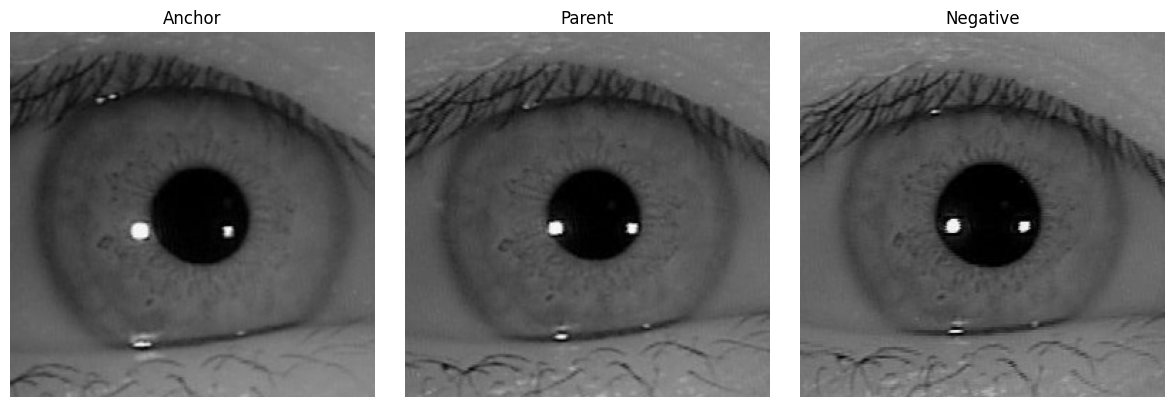

In [5]:
# Set the dataset to train mode
dataset.train()

# Load a batch of images
batch = next(iter(all_vs_all_dataset))
# Batch size
print("Batch size: ",batch[0].shape)

# Plot the images
for anchor, parent, negative, _ in zip(batch[0][0], batch[0][1], batch[0][2], batch[0][3]):
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))

    ax[0].imshow(anchor, cmap="gray")
    ax[0].set_title("Anchor")
    ax[0].axis("off")

    ax[1].imshow(parent, cmap="gray")
    ax[1].set_title("Parent")
    ax[1].axis("off")

    ax[2].imshow(negative, cmap="gray")
    ax[2].set_title("Negative")
    ax[2].axis("off")

    plt.tight_layout()
    plt.show()

# Set the dataset to evaluation mode
dataset.eval()

#### 5. All vs All Test

##### 5.1. Generate Embeddings

In [17]:
# Generate embeddings
embedding_list, labels_list = generate_embeddings(device, net, all_vs_all_dataset)

Generating embeddings: 100%|██████████| 59/59 [01:18<00:00,  1.33s/it] 


##### 5.2. Merge the Embeddings into a Matrix

In [7]:
embedding_array = embedding_list.numpy()

# Compute the cosine similarity matrix and convert it to a dissimilarity matrix
M = - cosine_similarity(embedding_array)

# Round the cosine similarity to 3 decimal places
M = np.round(M, 3)

# Normalize the cosine similarity to [0, 1]
M = (M + 1) / 2

##### 5.3. Identification Test

12
Threshold@EER: 0.0600


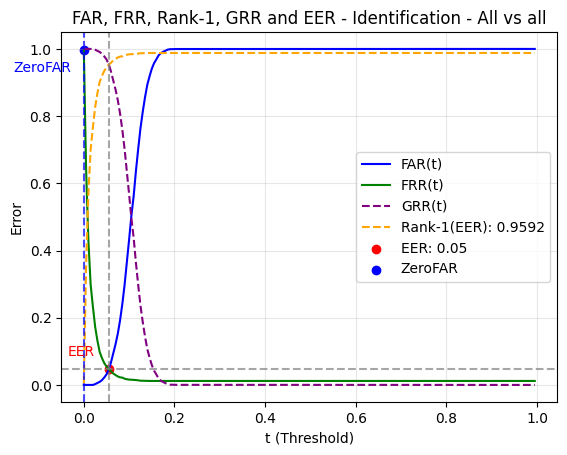

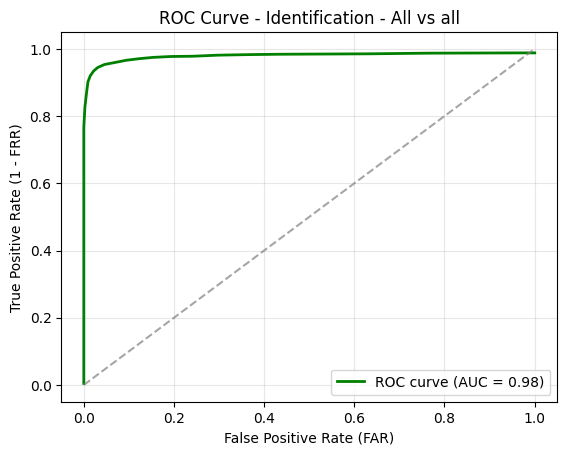

In [8]:
# Compute the thresholds, DIR, GRR, FAR, FRR
thresholds, DIR, GRR, FAR, FRR = identification_test_all_vs_all(M, labels_list)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=np.array(DIR), roc=True, titleRoc="ROC Curve - Identification - All vs all", titleEer="FAR, FRR, Rank-1, GRR and EER - Identification - All vs all")


##### 5.3. Verification Test

25
Threshold@EER: 0.1250


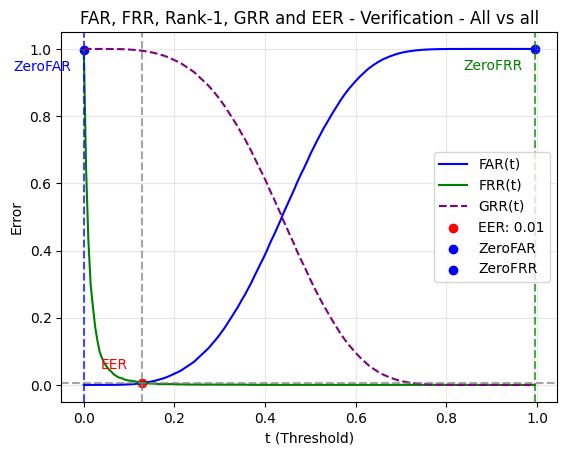

In [9]:
# Compute the GAR, FAR, FRR, GRR
GAR, FAR, FRR, GRR = verification_all_vs_all(M, labels_list)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=None, titleEer="FAR, FRR, Rank-1, GRR and EER - Verification - All vs all")

#### 6. Probe vs Gallery Test

##### 6.1. Split the Dataset

In [10]:
# Split the dataset into gallery and probe
gallery, probe = split_dataset_gallery_test(test_dataset, gallery_ratio=0.6, seed=20)

gallery = Subset(test_dataset, gallery)
probe = Subset(test_dataset, probe)

# Load the gallery and probe dataset
gallery_dataset = DataLoader(dataset=gallery, batch_size=64, shuffle=False, num_workers=8, pin_memory=False)
probe_dataset = DataLoader(dataset=probe, batch_size=64, shuffle=False, num_workers=8, pin_memory=False)

##### 6.2. Generate Embeddings

In [11]:
# Generate embeddings for gallery and probe
embedding_list_gallery, labels_list_gallery = generate_embeddings(device, net, gallery_dataset)
embedding_list_probe, labels_list_probe = generate_embeddings(device, net, probe_dataset)

Generating embeddings: 100%|██████████| 25/25 [01:09<00:00,  2.80s/it]


##### 6.3. Merge the Embeddings into a Matrix

In [12]:
embedding_list_gallery = embedding_list_gallery.numpy()
embedding_list_probe = embedding_list_probe.numpy()

# Compute the cosine similarity matrix and convert it to a dissimilarity matrix
M = - cosine_similarity(embedding_list_probe, embedding_list_gallery)
# Normalize the cosine similarity to [0, 1]
M = (np.round(M, 3) + 1) / 2

##### 6.4. Identification Test

12
Threshold@EER: 0.0600


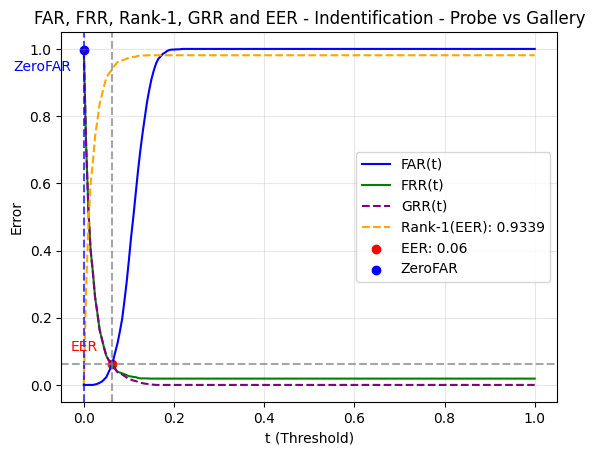

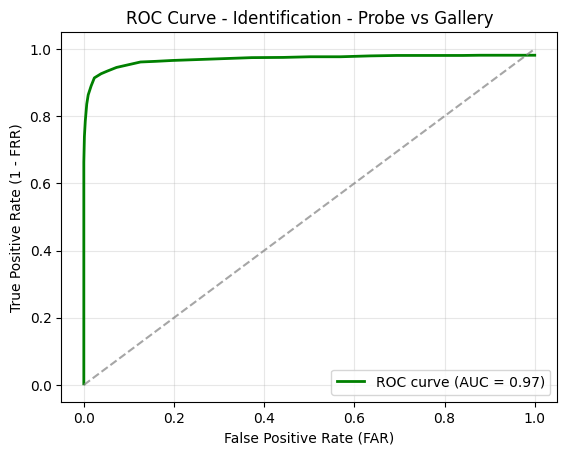

In [13]:
# Compute the thresholds, DIR, GRR, FAR, FRR
thresholds, DIR, GRR, FAR, FRR = identification_test_probe_vs_gallery(M, labels_list_probe, labels_list_gallery)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=np.array(DIR), roc=True, titleRoc="ROC Curve - Identification - Probe vs Gallery", titleEer="FAR, FRR, Rank-1, GRR and EER - Indentification - Probe vs Gallery")

##### 6.5. Verification Test

29
Threshold@EER: 0.1450


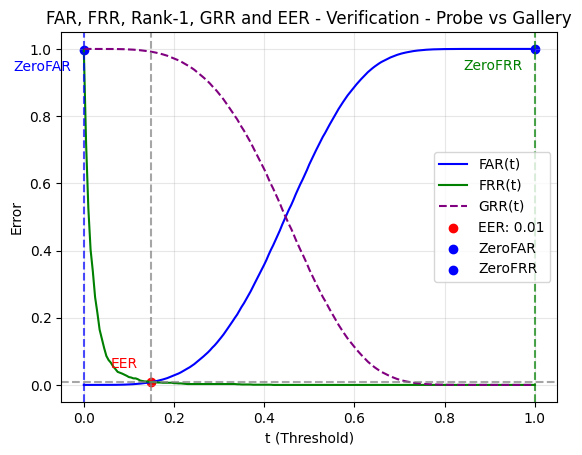

In [14]:
# Compute the GAR, FAR, FRR, GRR
GAR, FAR, FRR, GRR = verification_probe_vs_gallery(M, labels_list_probe, labels_list_gallery)

# Plot the FAR, FRR, Rank-1, GRR and EER
plot_far_frr_roc(thresholds, FAR, FRR, GRR, DIR=None, titleEer="FAR, FRR, Rank-1, GRR and EER - Verification - Probe vs Gallery")